In [ ]:
!pip install graphviz==0.9
!pip install pydot
!apt-get install graphviz

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-440
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [ ]:
import pandas as pd

uri = "https://gist.githubusercontent.com/guilhermesilveira/e99a526b2e7ccc6c3b70f53db43a87d2/raw/1605fc74aa778066bf2e6695e24d53cf65f2f447/machine-learning-carros-simulacao.csv"
dados = pd.read_csv(uri).drop(columns=["Unnamed: 0"], axis=1)
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano
0,30941.02,1,18,35085.22134
1,40557.96,1,20,12622.05362
2,89627.50,0,12,11440.79806
3,95276.14,0,3,43167.32682
4,117384.68,1,4,12770.11290


In [ ]:
# situação horrível de "azar" onde as classes estão ordenadas por padrão

dados_azar = dados.sort_values("vendido", ascending=True)
x_azar = dados_azar[["preco", "idade_do_modelo","km_por_ano"]]
y_azar = dados_azar["vendido"]
dados_azar.head()

,preco,vendido,idade_do_modelo,km_por_ano
4999,74023.29,0,12,24812.80412
5322,84843.49,0,13,23095.63834
5319,83100.27,0,19,36240.72746
5316,87932.13,0,16,32249.56426
5315,77937.01,0,15,28414.50704


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
import numpy as np

SEED = 301
np.random.seed(SEED)

modelo = DummyClassifier()
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com dummy stratified, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com dummy stratified, 10 = [49.79, 53.45]


/usr/local/lib/python3.6/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


In [ ]:
from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier

SEED = 301
np.random.seed(SEED)

modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = 10, return_train_score=False)
media = results['test_score'].mean()
desvio_padrao = results['test_score'].std()
print("Accuracy com cross validation, 10 = [%.2f, %.2f]" % ((media - 2 * desvio_padrao)*100, (media + 2 * desvio_padrao) * 100))

Accuracy com cross validation, 10 = [73.83, 77.73]


In [ ]:
# gerando dados elatorios de modelo de carro para simulacao de agrupamento ao usar nosso estimador

np.random.seed(SEED)
dados['modelo'] = dados.idade_do_modelo + np.random.randint(-2, 3, size=10000)
dados.modelo = dados.modelo + abs(dados.modelo.min()) + 1
dados.head()

,preco,vendido,idade_do_modelo,km_por_ano,modelo
0,30941.02,1,18,35085.22134,18
1,40557.96,1,20,12622.05362,24
2,89627.50,0,12,11440.79806,14
3,95276.14,0,3,43167.32682,6
4,117384.68,1,4,12770.11290,5


In [ ]:
def imprime_resultados(results):
  media = results['test_score'].mean() * 100
  desvio = results['test_score'].std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [ ]:
# GroupKFold para analisar como o modelo se comporta com novos grupos

from sklearn.model_selection import GroupKFold

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=2)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 75.78
Intervalo [73.67, 77.90]


In [ ]:
# GroupKFold em um pipeline com StandardScaler e SVC

from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline

SEED = 301
np.random.seed(SEED)

scaler = StandardScaler()
modelo = SVC()

pipeline = Pipeline([('transformacao',scaler), ('estimador',modelo)])

cv = GroupKFold(n_splits = 10)
results = cross_validate(pipeline, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 76.68
Intervalo [74.28, 79.08]


In [ ]:

SEED = 301
np.random.seed(SEED)

cv = GroupKFold(n_splits = 10)
modelo = DecisionTreeClassifier(max_depth=3)
results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=False)
imprime_resultados(results)

Accuracy médio 78.67
Intervalo [76.40, 80.94]


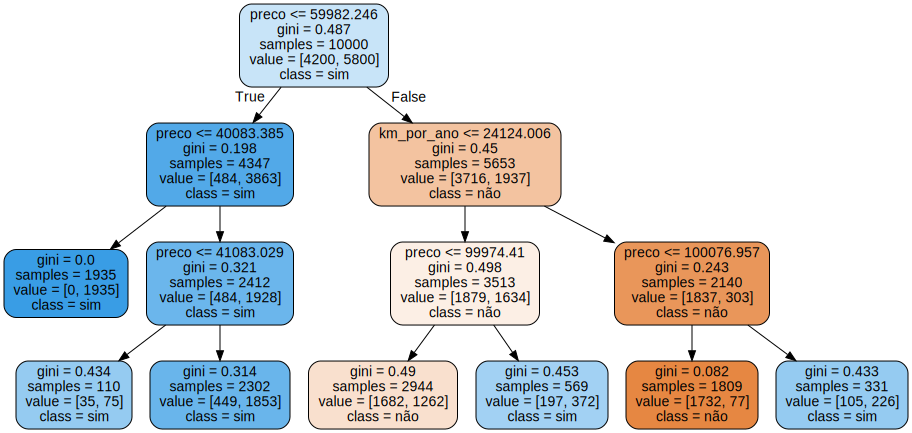

In [ ]:
# GroupKFold para analisar como o modelo se comporta com novos grupos
import graphviz
from sklearn.tree import export_graphviz

modelo.fit(x_azar, y_azar)

features = x_azar.columns
dot_data = export_graphviz(modelo, out_file = None, filled = True, rounded = True, class_names = ["não", "sim"], feature_names = features)
graph = graphviz.Source(dot_data)
graph

In [ ]:

def roda_arvore_de_decisao(max_depth):
  SEED = 301
  np.random.seed(SEED)
  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean()*100
  test_score = results['test_score'].mean()*100
  #print("Arvore Max depth =  %d, média treino = %.2f média teste = %.2f"% (max_depth, train_score ,test_score))
  tabela = [max_depth, train_score, test_score]
  return tabela

In [ ]:
resultados = [roda_arvore_de_decisao(i) for i in range(1,33)]
resultados = pd.DataFrame(resultados, columns = ["max_depth","train","test"])

# Validação de OverFit

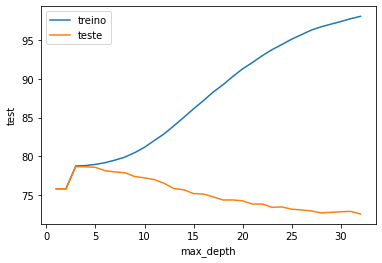

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(x = "max_depth", y="train", data=resultados)
sns.lineplot(x = "max_depth", y="test", data=resultados)

plt.legend(["treino","teste"])

In [ ]:
resultados.sort_values("test", ascending=False).head()

,max_depth,train,test
2,3,78.750993,78.672633
3,4,78.787628,78.632803
4,5,78.941007,78.555912
5,6,79.170115,78.123266
6,7,79.496806,77.963185


#Explorando hiperparametros em 2 dimensoes

In [ ]:

def roda_arvore_de_decisao(max_depth, min_samples_leaf):
  SEED = 301
  np.random.seed(SEED)
  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  train_score = results['train_score'].mean()*100
  test_score = results['test_score'].mean()*100
  #print("Arvore Max depth =  %d, média treino = %.2f média teste = %.2f"% (max_depth, train_score ,test_score))
  tabela = [max_depth, min_samples_leaf, train_score, test_score]
  return tabela

In [ ]:
def busca():
  resultados = []
  for max_depth in range(1,32):
    for min_samples_leaf in [32, 64, 128, 256, 512]:
      tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf)
      resultados.append(tabela)
  return resultados

busca()
resultados = pd.DataFrame(resultados, columns = ["max_depth","min_samples_leaf","train","test"])
resultados.head()

,max_depth,min_samples_leaf,train,test
0,1,NaN,75.791169,75.784219
1,2,NaN,75.791169,75.784219
2,3,NaN,78.750993,78.672633
3,4,NaN,78.787628,78.632803
4,5,NaN,78.941007,78.555912


In [ ]:
resultados.head()

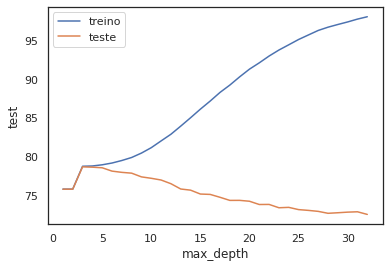

In [ ]:
sns.lineplot(x = "max_depth", y="train", data=resultados)
sns.lineplot(x = "max_depth", y="test", data=resultados)

plt.legend(["treino","teste"])

In [ ]:
corr = resultados.corr()

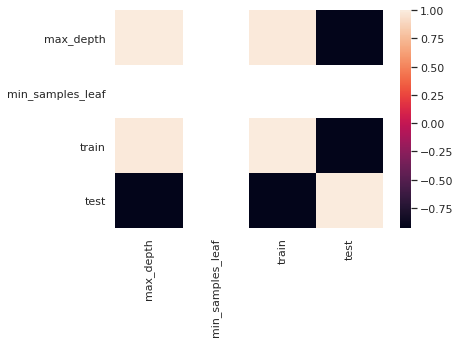

In [ ]:
sns.heatmap(corr)

In [ ]:
pd.scatter_matrix(resultados, figsize(14,8), alpha = 0.3)

AttributeError: ignored

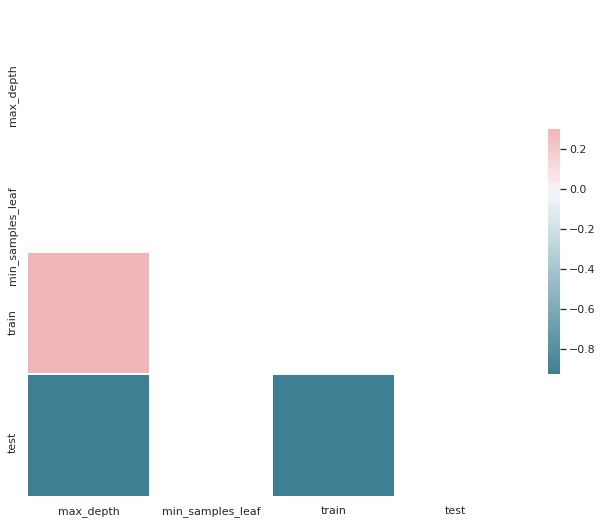

In [ ]:
from string import ascii_letters
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Explorando 3 dimensões de hiperparametro


In [ ]:
def roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split):
  SEED = 301
  np.random.seed(SEED)

  cv = GroupKFold(n_splits = 10)
  modelo = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf = min_samples_leaf, min_samples_split = min_samples_split)
  results = cross_validate(modelo, x_azar, y_azar, cv = cv, groups = dados.modelo, return_train_score=True)
  fit_time = results['fit_time'].mean()
  score_time = results['score_time'].mean()
  train_score = results['train_score'].mean() * 100
  test_score = results['test_score'].mean() * 100

  tabela = [max_depth, min_samples_leaf, min_samples_split, train_score, test_score, fit_time, score_time]
  return tabela

def busca():
  resultados = []
  for max_depth in range(1,33):
    for min_samples_leaf in [32, 64, 128, 256]:
        for min_samples_split in [32, 64, 128, 256]:
          tabela = roda_arvore_de_decisao(max_depth, min_samples_leaf, min_samples_split)
          resultados.append(tabela)
  resultados = pd.DataFrame(resultados, columns= ["max_depth","min_samples_leaf", "min_samples_split", "train","test","fit_time", "score_time"])
  return resultados

resultados = busca()
resultados.head()

,max_depth,min_samples_leaf,min_samples_split,train,test,fit_time,score_time
0,1,32,32,75.791169,75.784219,0.006109,0.001121
1,1,32,64,75.791169,75.784219,0.005495,0.001057
2,1,32,128,75.791169,75.784219,0.005633,0.001116
3,1,32,256,75.791169,75.784219,0.005826,0.001145
4,1,64,32,75.791169,75.784219,0.005488,0.001059


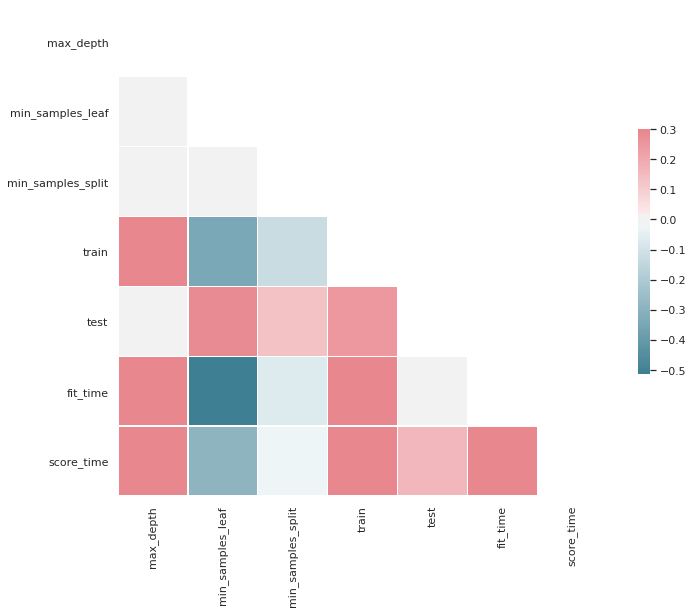

In [ ]:
corr = resultados.corr()

sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

# Explorando espaço de hiperparametros com GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

SEED =301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth"         : [3,5],
    "min_samples_split" : [32,64,128],
    "min_samples_leaf"  : [32,64,128],
    "criterion"         : ["gini", "entropy"]
}
busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv = GroupKFold(n_splits=10))
busca.fit(x_azar, y_azar, groups=dados.modelo)
resultados= pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
0,0.011370,0.000992,0.001435,0.000197,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
1,0.010611,0.000321,0.001256,0.000058,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
2,0.010388,0.000138,0.001195,0.000057,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
3,0.010461,0.000079,0.001281,0.000103,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1
4,0.010310,0.000192,0.001208,0.000162,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.804757,0.793667,0.793313,0.78408,0.783181,0.797809,0.762866,0.781818,0.77551,0.790262,0.786726,0.011361,1


In [ ]:
print(busca.best_params_)
print(busca.best_score_*100)

{'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 32, 'min_samples_split': 32}
78.67263337284332


In [ ]:
melhor = busca.best_estimator_
melhor

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
from sklearn.metrics import accuracy_score
predicoes = melhor.predict(x_azar)

# evitar essa abordagem porque esta sera otimista
accuracy = accuracy_score(predicoes, y_azar)*100
print("Accuracy para os dados foi %.2f%%"%accuracy)

Accuracy para os dados foi 78.75%


# estimativa sem esse vicios nos dados que ja vi
No caso de cross validation com busca de hiper paarametros fazemos uma nova validacoes cruzada, cham-se nested cross valdiation

Como pandas nao suporta nested validation  com groupK Fold nao conseguimos prever os resultados para novos bugs

In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = GroupKFold(n_splits=10), groups=dados.modelo)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
ValueError: The 'groups' parameter should not be None.

  FitFailedWarning)


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

SEED =301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth"         : [3,5],
    "min_samples_split" : [32,64,128],
    "min_samples_leaf"  : [32,64,128],
    "criterion"         : ["gini", "entropy"]
}
busca = GridSearchCV(DecisionTreeClassifier(), espaco_de_parametros, cv = KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
resultados= pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.010363,0.000935,0.001401,0.000139,gini,3,32,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
1,0.009332,0.000123,0.001315,0.000097,gini,3,32,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
2,0.009419,0.000174,0.001316,0.000074,gini,3,32,128,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
3,0.009315,0.000075,0.001193,0.000041,gini,3,64,32,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1
4,0.009391,0.000219,0.001344,0.000222,gini,3,64,64,"{'criterion': 'gini', 'max_depth': 3, 'min_sam...",0.784,0.776,0.8025,0.793,0.7795,0.787,0.009618,1


In [ ]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=10, shuffle=True))
scores

array([0.805, 0.774, 0.781, 0.784, 0.789, 0.794, 0.785, 0.756, 0.811,
       0.788])

In [ ]:
def imprime_scores(scores):
  media = scores.mean() * 100
  desvio = scores.std() * 100
  print("Accuracy médio %.2f" % media)
  print("Intervalo [%.2f, %.2f]" % (media - 2 * desvio, media + 2 * desvio))

In [ ]:
imprime_scores(scores)

Accuracy médio 78.67
Intervalo [75.75, 81.59]


In [ ]:
melhor = busca.best_estimator_
melhor


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=32,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

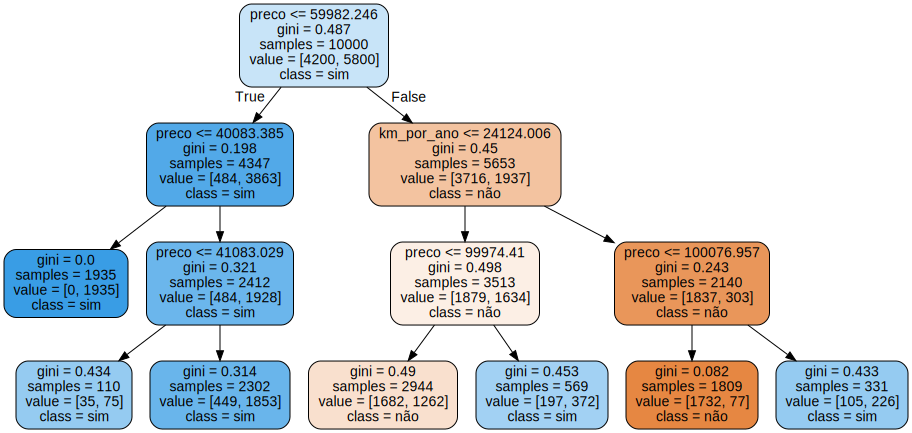

In [ ]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file = None, filled = True, rounded = True, class_names = ["não", "sim"], feature_names = features)
graph = graphviz.Source(dot_data)
graph

# Busca aleatorio: RandomSearch

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

SEED =301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth"         : [3,5],
    "min_samples_split" : [32,64,128],
    "min_samples_leaf"  : [32,64,128],
    "criterion"         : ["gini", "entropy"]
}
busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, random_state = SEED, n_iter = 16, cv = KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
resultados= pd.DataFrame(busca.cv_results_)
resultados.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.014391,0.001941,0.001633,0.000116,128,128,5,gini,"{'min_samples_split': 128, 'min_samples_leaf':...",0.784,0.769,0.7985,0.793,0.7730,0.7835,0.011278,13
1,0.009794,0.000050,0.001496,0.000065,64,32,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
2,0.010010,0.000086,0.001529,0.000053,64,128,3,gini,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.776,0.8025,0.793,0.7795,0.7870,0.009618,1
3,0.020041,0.000233,0.001697,0.000328,32,64,5,entropy,"{'min_samples_split': 32, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7
4,0.020273,0.000395,0.001608,0.000072,64,64,5,entropy,"{'min_samples_split': 64, 'min_samples_leaf': ...",0.784,0.769,0.8005,0.793,0.7730,0.7839,0.011825,7


In [ ]:
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=10, shuffle=True))
scores
imprime_scores(scores)

Accuracy médio 78.70
Intervalo [76.70, 80.70]


In [ ]:
melhor = busca.best_estimator_
melhor


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=32, min_samples_split=64,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

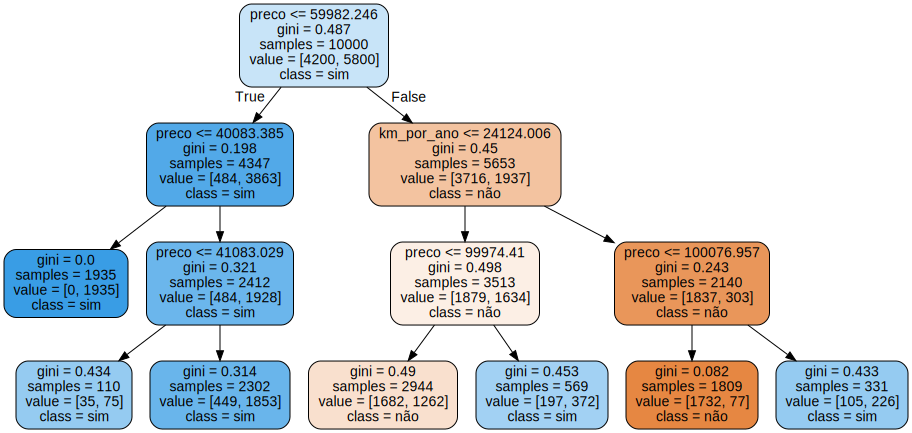

In [ ]:
features = x_azar.columns
dot_data = export_graphviz(melhor, out_file = None, filled = True, rounded = True, class_names = ["não", "sim"], feature_names = features)
graph = graphviz.Source(dot_data)
graph

# Customizando espaco de hiperparametro

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

SEED =301
np.random.seed(SEED)

espaco_de_parametros = {
    "max_depth"         : [3, 5, 10, 15, 20, 30, None],
    "min_samples_split" : randint(32,128),
    "min_samples_leaf"  : randint(32,128),
    "criterion"         : ["gini", "entropy"]
}
busca = RandomizedSearchCV(DecisionTreeClassifier(), espaco_de_parametros, random_state = SEED, n_iter = 64, cv = KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
resultados= pd.DataFrame(busca.cv_results_)
resultados.head()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=10, shuffle=True))
scores
imprime_scores(scores)

Accuracy médio 78.68
Intervalo [75.96, 81.40]


In [ ]:
imprime_scores(scores)
melhor = busca.best_estimator_
melhor


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=3, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=71, min_samples_split=100,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [ ]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media.iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 71, 'min_samples_split': 100}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 69, 'min_samples_split': 124}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 63, 'min_samples_split': 88}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 67, 'min_samples_split': 76}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 65, 'min_samples_split': 50}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 120, 'min_samples_split': 46}
0.787 +-(0.019) {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 53, 'min_samples_split': 111}
0.787 +-(0.019) {'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 106, 'min_samples_split': 108}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 67}
0.784 +-(0.024) {'criterion': 'gini', 'max_depth': 5, '

# Comparadano GridSearchCV com o RandomizeSearchCV

In [ ]:
from sklearn.ensemble import RandomForestClassifier
import time
SEED =301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators"      : [10,100],
    "max_depth"         : [3,5],
    "min_samples_split" : [32,64,128],
    "min_samples_leaf"  : [32,64,128],
    "bootstrap"         : [True, False],
    "criterion"         : ["gini", "entropy"]
}

tic = time.time()
busca = GridSearchCV(RandomForestClassifier(), espaco_de_parametros, cv = KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = (tac-tic)
print("Tempo %.2f segundos" % tempo_que_passou)

resultados= pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 205.71 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.038975,0.003161,0.004054,0.000831,True,gini,3,32,32,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7745,0.7560,0.7490,0.7850,0.7450,0.7619,0.015357,130
1,0.334008,0.004098,0.019637,0.000731,True,gini,3,32,32,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7555,0.7945,0.7850,0.7625,0.7726,0.014685,93
2,0.037898,0.002693,0.003603,0.000252,True,gini,3,32,64,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7780,0.7635,0.7835,0.7845,0.7560,0.7731,0.011373,89
3,0.330612,0.005337,0.019335,0.000275,True,gini,3,32,64,100,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7425,0.7550,0.7950,0.7850,0.7620,0.7679,0.019356,119
4,0.037224,0.003243,0.003811,0.000516,True,gini,3,32,128,10,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7405,0.7485,0.7760,0.7630,0.7607,0.014250,135


In [ ]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.780 +-(0.020) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.020) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 32, 'min_samples_split': 128, 'n_estimators': 10}
0.778 +-(0.030) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.027) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 10}
0.778 +-(0.033) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 64, 'min_samples_split': 64, 'n_estimators': 100}


In [ ]:
tic = time.time()
#nao roda no colab de tao demorado #scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=10, shuffle=True))
tac = time.time()
tempo_que_passou = (tac-tic)
print("Tempo %.2f segundos" % tempo_que_passou)
#imprime_scores(scores)

Tempo 0.00 segundos
Accuracy médio 77.20
Intervalo [73.20, 81.20]


In [ ]:
SEED =301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators"      : [10,100],
    "max_depth"         : [3,5],
    "min_samples_split" : [32,64,128],
    "min_samples_leaf"  : [32,64,128],
    "bootstrap"         : [True, False],
    "criterion"         : ["gini", "entropy"]
}
tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(), espaco_de_parametros, random_state = SEED, n_iter = 20, cv = KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = (tac-tic)
print("Tempo %.2f segundos" % tempo_que_passou)

resultados= pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 30.43 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,param_criterion,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.426687,0.006583,0.019651,0.000030,100,32,128,3,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7270,0.7580,0.7950,0.7850,0.7625,0.7655,0.023656,13
1,0.053780,0.003445,0.003816,0.000062,10,32,128,5,entropy,True,"{'n_estimators': 10, 'min_samples_split': 32, ...",0.7425,0.7555,0.7915,0.7745,0.7630,0.7654,0.016687,15
2,0.579799,0.009081,0.022808,0.000349,100,32,32,5,entropy,True,"{'n_estimators': 100, 'min_samples_split': 32,...",0.7760,0.7585,0.7945,0.7855,0.7625,0.7754,0.013559,3
3,0.036748,0.000957,0.003618,0.000261,10,128,32,3,gini,True,"{'n_estimators': 10, 'min_samples_split': 128,...",0.7510,0.7580,0.7725,0.7845,0.7445,0.7621,0.014558,19
4,0.055623,0.003801,0.003548,0.000069,10,64,32,3,entropy,False,"{'n_estimators': 10, 'min_samples_split': 64, ...",0.7755,0.7555,0.7500,0.7725,0.7620,0.7631,0.009723,17


In [ ]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.777 +-(0.026) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.776 +-(0.028) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'gini', 'bootstrap': False}
0.775 +-(0.027) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 32, 'max_depth': 5, 'criterion': 'entropy', 'bootstrap': True}
0.775 +-(0.028) {'n_estimators': 100, 'min_samples_split': 32, 'min_samples_leaf': 128, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': True}
0.775 +-(0.028) {'n_estimators': 100, 'min_samples_split': 64, 'min_samples_leaf': 64, 'max_depth': 3, 'criterion': 'gini', 'bootstrap': False}


In [ ]:
tic = time.time()
scores = cross_val_score(busca, x_azar, y_azar, cv = KFold(n_splits=10, shuffle=True))
tac = time.time()
tempo_que_passou = (tac-tic)
print("Tempo %.2f segundos" % tempo_que_passou)
imprime_scores(scores)

Tempo 278.55 segundos
Accuracy médio 77.20
Intervalo [73.20, 81.20]


In [ ]:
SEED =301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators"      : randint(10,100),
    "max_depth"         : randint(1,10),
    "min_samples_split" : randint(32,128),
    "min_samples_leaf"  : randint(32,128),
    "bootstrap"         : [True, False],
    "criterion"         : ["gini", "entropy"]
}
tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(), espaco_de_parametros, random_state = SEED, n_iter = 20, cv = KFold(n_splits=5, shuffle=True))
busca.fit(x_azar, y_azar)
tac = time.time()
tempo_que_passou = (tac-tic)
print("Tempo %.2f segundos" % tempo_que_passou)

resultados= pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 36.92 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.436030,0.002734,0.019322,0.000252,False,gini,8,100,50,71,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7775,0.7565,0.7970,0.7880,0.7620,0.7762,0.015253,8
1,0.350793,0.011253,0.013569,0.000086,False,entropy,3,108,124,66,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7750,0.7575,0.7905,0.7855,0.7595,0.7736,0.013321,15
2,0.328173,0.003705,0.019535,0.000283,True,gini,9,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7740,0.7570,0.7950,0.7830,0.7615,0.7741,0.013908,13
3,0.115205,0.001280,0.009009,0.000180,True,gini,1,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.6845,0.7250,0.7450,0.7315,0.7380,0.7248,0.021219,20
4,0.306107,0.009639,0.017264,0.000277,True,gini,6,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7755,0.7585,0.8020,0.7880,0.7630,0.7774,0.016036,5


In [ ]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.781 +-(0.027) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 53, 'min_samples_split': 100, 'n_estimators': 62}
0.780 +-(0.029) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 83, 'min_samples_split': 38, 'n_estimators': 84}
0.778 +-(0.028) {'bootstrap': True, 'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 47, 'min_samples_split': 43, 'n_estimators': 21}
0.778 +-(0.032) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 9, 'min_samples_leaf': 64, 'min_samples_split': 72, 'n_estimators': 74}
0.777 +-(0.032) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 52, 'min_samples_split': 88, 'n_estimators': 68}


# Se eu não posso ou não consigo usar cross validation
- Treino
- Teste
- Validação

In [ ]:
# 0.6 treino
# 0.2 teste
# 0.2 validacao


from sklearn.model_selection import train_test_split
x_treino_teste, x_validacao, y_treino_teste, y_validacao = train_test_split(x_azar, y_azar, test_size=0.2, shuffle=True, stratify = y_azar)

In [ ]:
from sklearn.model_selection import StratifiedShuffleSplit


SEED =301
np.random.seed(SEED)

espaco_de_parametros = {
    "n_estimators"      : randint(10,100),
    "max_depth"         : randint(1,10),
    "min_samples_split" : randint(32,128),
    "min_samples_leaf"  : randint(32,128),
    "bootstrap"         : [True, False],
    "criterion"         : ["gini", "entropy"]
}

split = StratifiedShuffleSplit(n_splits=5, test_size=0.25) 
tic = time.time()
busca = RandomizedSearchCV(RandomForestClassifier(), espaco_de_parametros, random_state = SEED, n_iter = 5, cv = split)
busca.fit(x_treino_teste, y_treino_teste)
tac = time.time()
tempo_que_passou = (tac-tic)
print("Tempo %.2f segundos" % tempo_que_passou)

resultados= pd.DataFrame(busca.cv_results_)
resultados.head()

Tempo 7.07 segundos


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.336321,0.012498,0.019260,0.000331,False,gini,8,100,50,71,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.7645,0.7830,0.7875,0.7750,0.7800,0.7780,0.007880,1
1,0.278354,0.006985,0.013887,0.000101,False,entropy,3,108,124,66,"{'bootstrap': False, 'criterion': 'entropy', '...",0.7695,0.7780,0.7830,0.7760,0.7735,0.7760,0.004506,3
2,0.265067,0.004987,0.020118,0.001911,True,gini,9,126,84,77,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7690,0.7780,0.7790,0.7715,0.7740,0.7743,0.003789,4
3,0.111920,0.004208,0.009775,0.000846,True,gini,1,57,73,50,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7195,0.7290,0.7375,0.7685,0.7295,0.7368,0.016845,5
4,0.248911,0.002284,0.017405,0.000274,True,gini,6,52,88,68,"{'bootstrap': True, 'criterion': 'gini', 'max_...",0.7655,0.7755,0.7800,0.7850,0.7770,0.7766,0.006430,2


In [ ]:
resultados_ordenados_pela_media = resultados.sort_values("mean_test_score", ascending=False)
for indice, linha in resultados_ordenados_pela_media[:5].iterrows():
  print("%.3f +-(%.3f) %s" % (linha.mean_test_score, linha.std_test_score*2, linha.params))

0.778 +-(0.016) {'bootstrap': False, 'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 100, 'min_samples_split': 50, 'n_estimators': 71}
0.777 +-(0.013) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 52, 'min_samples_split': 88, 'n_estimators': 68}
0.776 +-(0.009) {'bootstrap': False, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 108, 'min_samples_split': 124, 'n_estimators': 66}
0.774 +-(0.008) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 9, 'min_samples_leaf': 126, 'min_samples_split': 84, 'n_estimators': 77}
0.737 +-(0.034) {'bootstrap': True, 'criterion': 'gini', 'max_depth': 1, 'min_samples_leaf': 57, 'min_samples_split': 73, 'n_estimators': 50}


In [ ]:
tic = time.time()
scores = cross_val_score(busca, x_validacao, y_validacao, cv = split)
tac = time.time()
tempo_que_passou = (tac-tic)
print("Tempo %.2f segundos" % tempo_que_passou)
imprime_scores(scores)

Tempo 13.42 segundos
Accuracy médio 73.68
Intervalo [71.18, 76.18]
